In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')
data2 = data.copy()
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2287905068.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
label = data['label']
attack_cat = data['attack_cat']
data = data.drop(columns=['label', 'attack_cat'])

In [4]:
from sklearn.model_selection import KFold

In [5]:
import time

Testing: 100%|██████████| 3969/3969 [00:18<00:00, 212.85batch/s]


Test Loss: 0.0205, Test Accuracy: 0.9877, Test F1: 0.9889


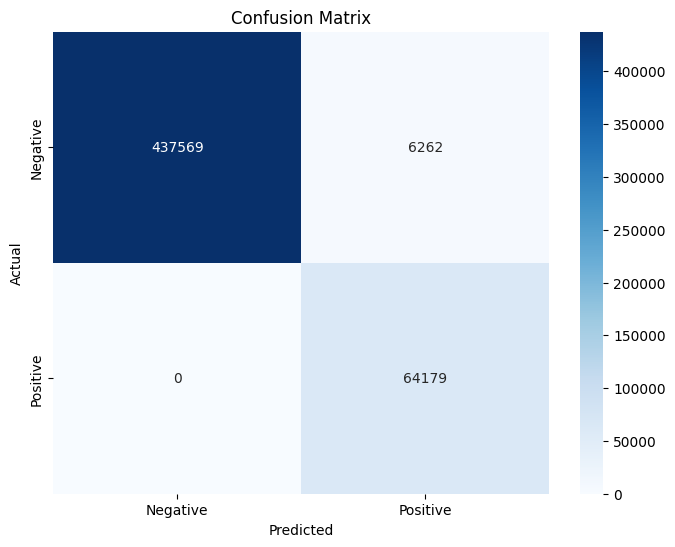

C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ypred'] = model.test_predicted
C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['actual'] = y_test
c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which use

Test Loss: 0.1504, Test Accuracy: 0.9177, Test F1: 0.9290


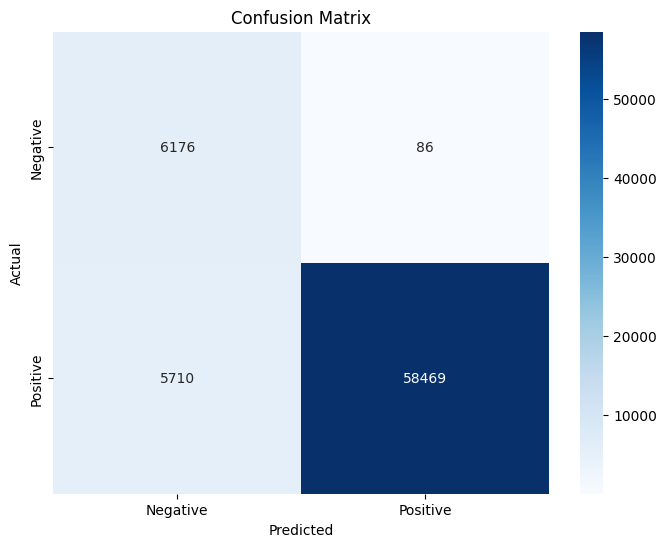

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Test Loss: 0.0207, Test Accuracy: 0.9875, Test F1: 0.9887


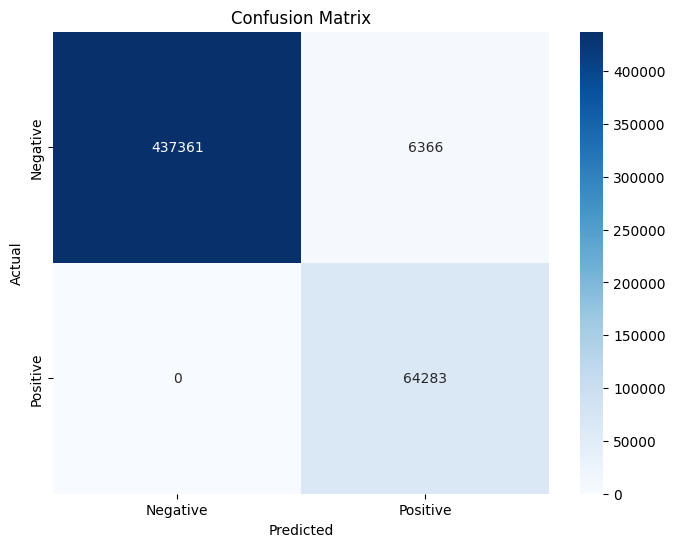

C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ypred'] = model.test_predicted
C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['actual'] = y_test
c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which use

Test Loss: 0.1470, Test Accuracy: 0.9177, Test F1: 0.9290


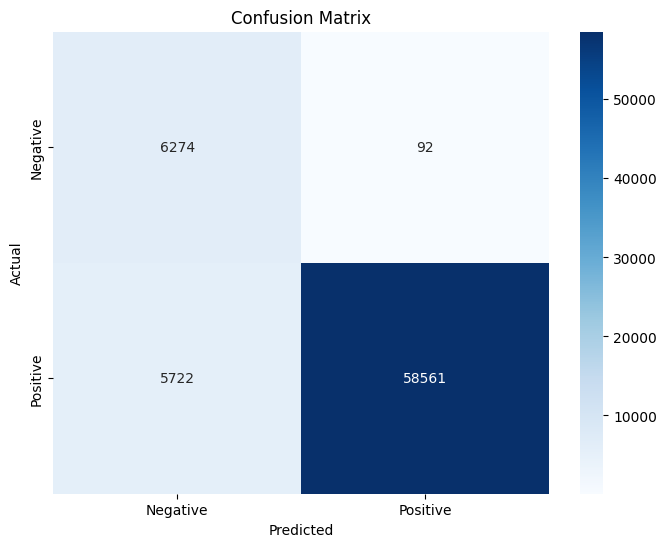

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Test Loss: 0.0201, Test Accuracy: 0.9877, Test F1: 0.9889


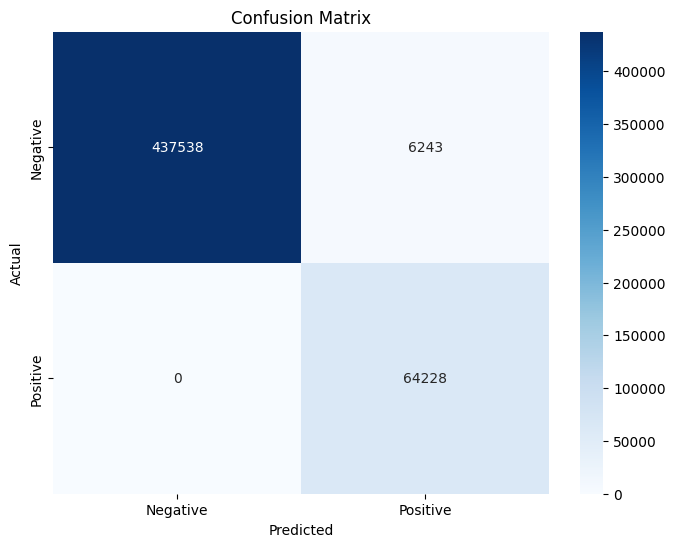

C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ypred'] = model.test_predicted
C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['actual'] = y_test
c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which use

Test Loss: 0.1385, Test Accuracy: 0.9185, Test F1: 0.9300


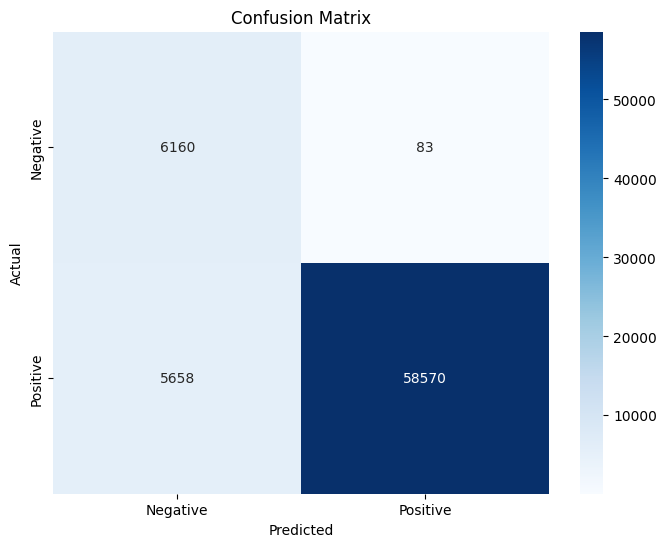

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Test Loss: 0.0204, Test Accuracy: 0.9877, Test F1: 0.9889


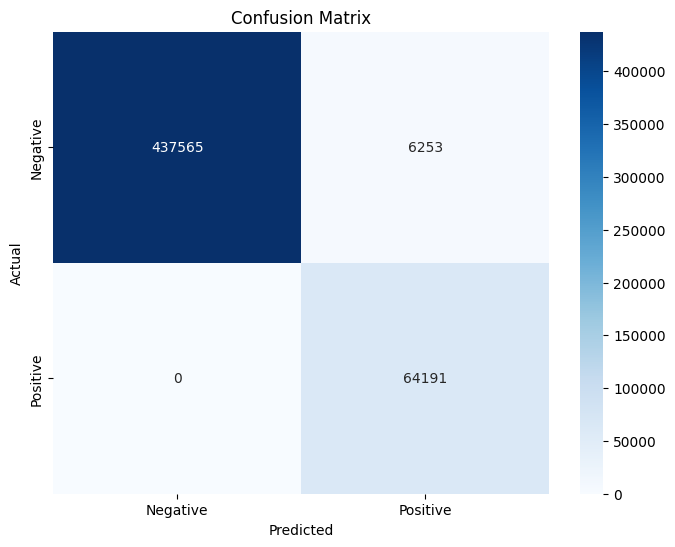

C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ypred'] = model.test_predicted
C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['actual'] = y_test
c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which use

Test Loss: 0.1509, Test Accuracy: 0.9161, Test F1: 0.9279


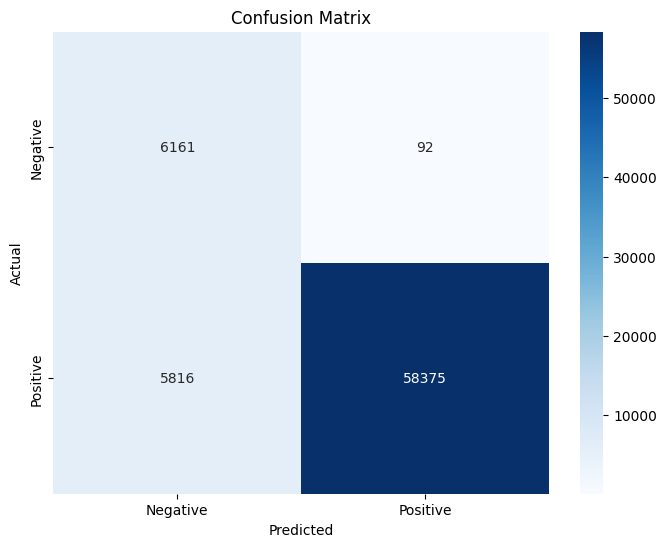

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Test Loss: 0.0201, Test Accuracy: 0.9879, Test F1: 0.9890


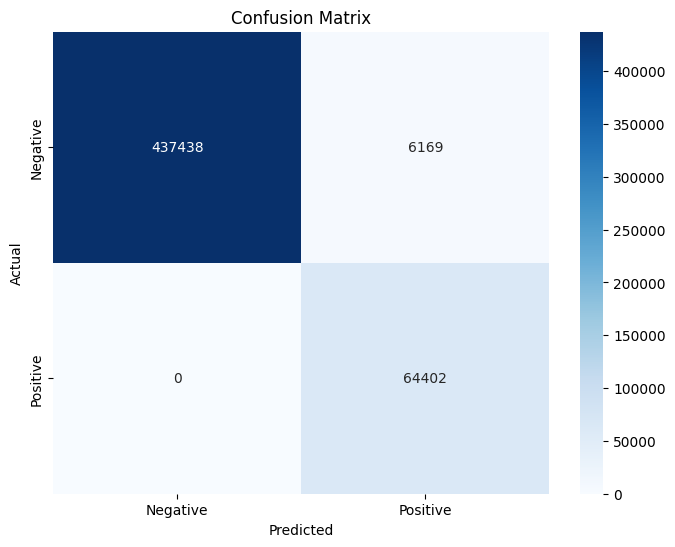

C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ypred'] = model.test_predicted
C:\Users\kregh\AppData\Local\Temp\ipykernel_19524\2399931483.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['actual'] = y_test
c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which use

Test Loss: 0.1436, Test Accuracy: 0.9165, Test F1: 0.9284


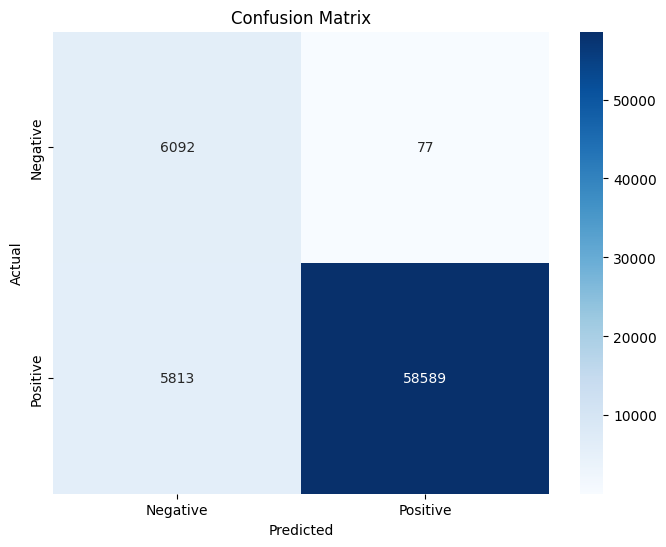

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(data):
    time.sleep(20)
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    batch_size = 128
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_features = X_train_tensor.shape[1]
    fc_size = 256
    save_dir = './Models/saved_models/'
    model = NNdynamic(n_features, fc_size, device, save_dir)
    model.load_model('./Models/saved_models/02/smote/01-256/PB_epoch_5.pth')
    model.test(test_loader)
    labels = test_dataset.tensors[1]
    plot_confusion_matrix(labels, model.test_predicted)
    X_test['ypred'] = model.test_predicted
    X_test['actual'] = y_test
    X_test = X_test[X_test['ypred'] == 1]
    y_test = X_test['actual']
    X_test = X_test.drop(columns=['actual', 'ypred'])
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_features = X_train_tensor.shape[1]
    fc_size = 512
    save_dir = './Models/saved_models/02/standard/1L512'
    model2 = NNdynamic(n_features, fc_size, device, save_dir)
    model2.load_model('./Models/saved_models/02/standard/1L512/PB_epoch_5.pth')
    model2.test(test_loader)
    labels = test_dataset.tensors[1]
    plot_confusion_matrix(labels, model2.test_predicted)